In [13]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina"

import os
import re
import random

In [14]:
# root_dir = "/Users/wjohns/work/quigley_lab_local/projects/tf-binding/repo/src/inference"
root_dir = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/interpretability"
data_dir = os.path.join(root_dir, "CDT_output")

cdt_json_ids = [os.path.basename(i) for i in os.listdir(data_dir) if i.endswith(".csv") and i.startswith("AR_context")]
mt_json_ids = [os.path.basename(i) for i in os.listdir(data_dir) if i.endswith(".csv") and i.startswith("AR_CDT_mutant")]

cdt_json_ids = [re.findall(r'\d+', i)[0] for i in cdt_json_ids]
mt_json_ids = [re.findall(r'\d+', i)[0] for i in mt_json_ids]

cdt_files = [os.path.join(data_dir, i) for i in os.listdir(data_dir) if i.endswith(".csv") and i.startswith("AR_context")]
mt_files =  [os.path.join(data_dir, i) for i in os.listdir(data_dir) if i.endswith(".csv") and i.startswith("AR_CDT_mutant")]

In [15]:
dfs_list = list()
for i in range(len(cdt_files)):
    df_tmp = pd.read_csv(cdt_files[i], index_col=0).reset_index()
    df_tmp['json_id'] = cdt_json_ids[i]
    df_tmp['sampleID'] = df_tmp.apply(
        lambda row: f"{row['index']}_{row['json_id']}", axis=1
    )

    dfs_list.append(df_tmp)
cdt = pd.concat(dfs_list, ignore_index=True)
cdt = cdt.reset_index().rename(columns={'index': 'sample'})

dfs_list = list()
for i in range(len(mt_files)):
    df_tmp = pd.read_csv(mt_files[i], index_col=0).reset_index()
    df_tmp['json_id'] = mt_json_ids[i]
    df_tmp['sampleID'] = df_tmp.apply(
        lambda row: f"{row['index']}_{row['json_id']}", axis=1
    )

    dfs_list.append(df_tmp)

mt = pd.concat(dfs_list, ignore_index=True) # Jensen-Shannon Divergence
del df_tmp, dfs_list

cdt.to_csv(os.path.join(data_dir, "AR_CDT_summary_full.csv"), index=False)
mt.to_csv(os.path.join(data_dir, "AR_mutant_predictions_full.csv"), index=False)

In [16]:
positives = cdt[cdt['target'] == 1]
negatives = cdt[cdt['target'] == 0]

assert 0 not in set(positives['target'])
assert 1 not in set(negatives['target'])

positive_indices = positives['sampleID'].tolist()
negative_indices = negatives['sampleID'].tolist()

In [17]:
p_mt = mt[mt['sampleID'].isin(positive_indices)]
n_mt = mt[mt['sampleID'].isin(negative_indices)]

# Choose whether to look at positives or negatives
mt_subset = p_mt
# mt_subset = n_mt


mt_subset = mt_subset.drop(['index', 'json_id'], axis=1)
mt_subset.columns

Index(['shuffle_1', 'shuffle_2', 'shuffle_3', 'shuffle_4', 'shuffle_5',
       'shuffle_6', 'shuffle_7', 'shuffle_8', 'shuffle_9', 'shuffle_10',
       'shuffle_11', 'shuffle_12', 'shuffle_13', 'shuffle_14', 'shuffle_15',
       'shuffle_16', 'shuffle_17', 'shuffle_18', 'shuffle_19', 'shuffle_20',
       'sampleID'],
      dtype='object')

In [12]:
positives.to_csv(os.path.join(data_dir, "AR_pos_CDT.csv"), index=False)
negatives.to_csv(os.path.join(data_dir, "AR_neg_CDT.csv"), index=False)

p_mt.to_csv(os.path.join(data_dir, "AR_pos_mutant_predictions.csv"), 
            index=False)
n_mt.to_csv(os.path.join(data_dir, "AR_neg_mutant_predictions.csv"), 
            index=False)

In [43]:
melted = mt_subset.melt(id_vars="sampleID", var_name="shuffle", value_name="prediction")
melted['shuffle'] = [i.split("_")[1] for i in melted['shuffle']]
melted

sampleID shuffle  prediction
0           0_9       1    0.784488
1           1_9       1    0.004838
2           2_9       1    0.261926
3           3_9       1    0.000252
4           4_9       1    0.016751
...         ...     ...         ...
106675    700_8      20    0.415537
106676    701_8      20    0.109997
106677    702_8      20    0.034456
106678    703_8      20    0.015182
106679    704_8      20    0.033360

[106680 rows x 3 columns]

In [44]:
n_samples = 20
samples = random.sample(
    sorted(melted['sampleID']),
    n_samples,
)

subset = melted[melted['sampleID'].isin(samples)]
subset['sampleID'] = [str(i) for i in subset['sampleID']]

/tmp/ipykernel_215473/2633670654.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['sampleID'] = [str(i) for i in subset['sampleID']]


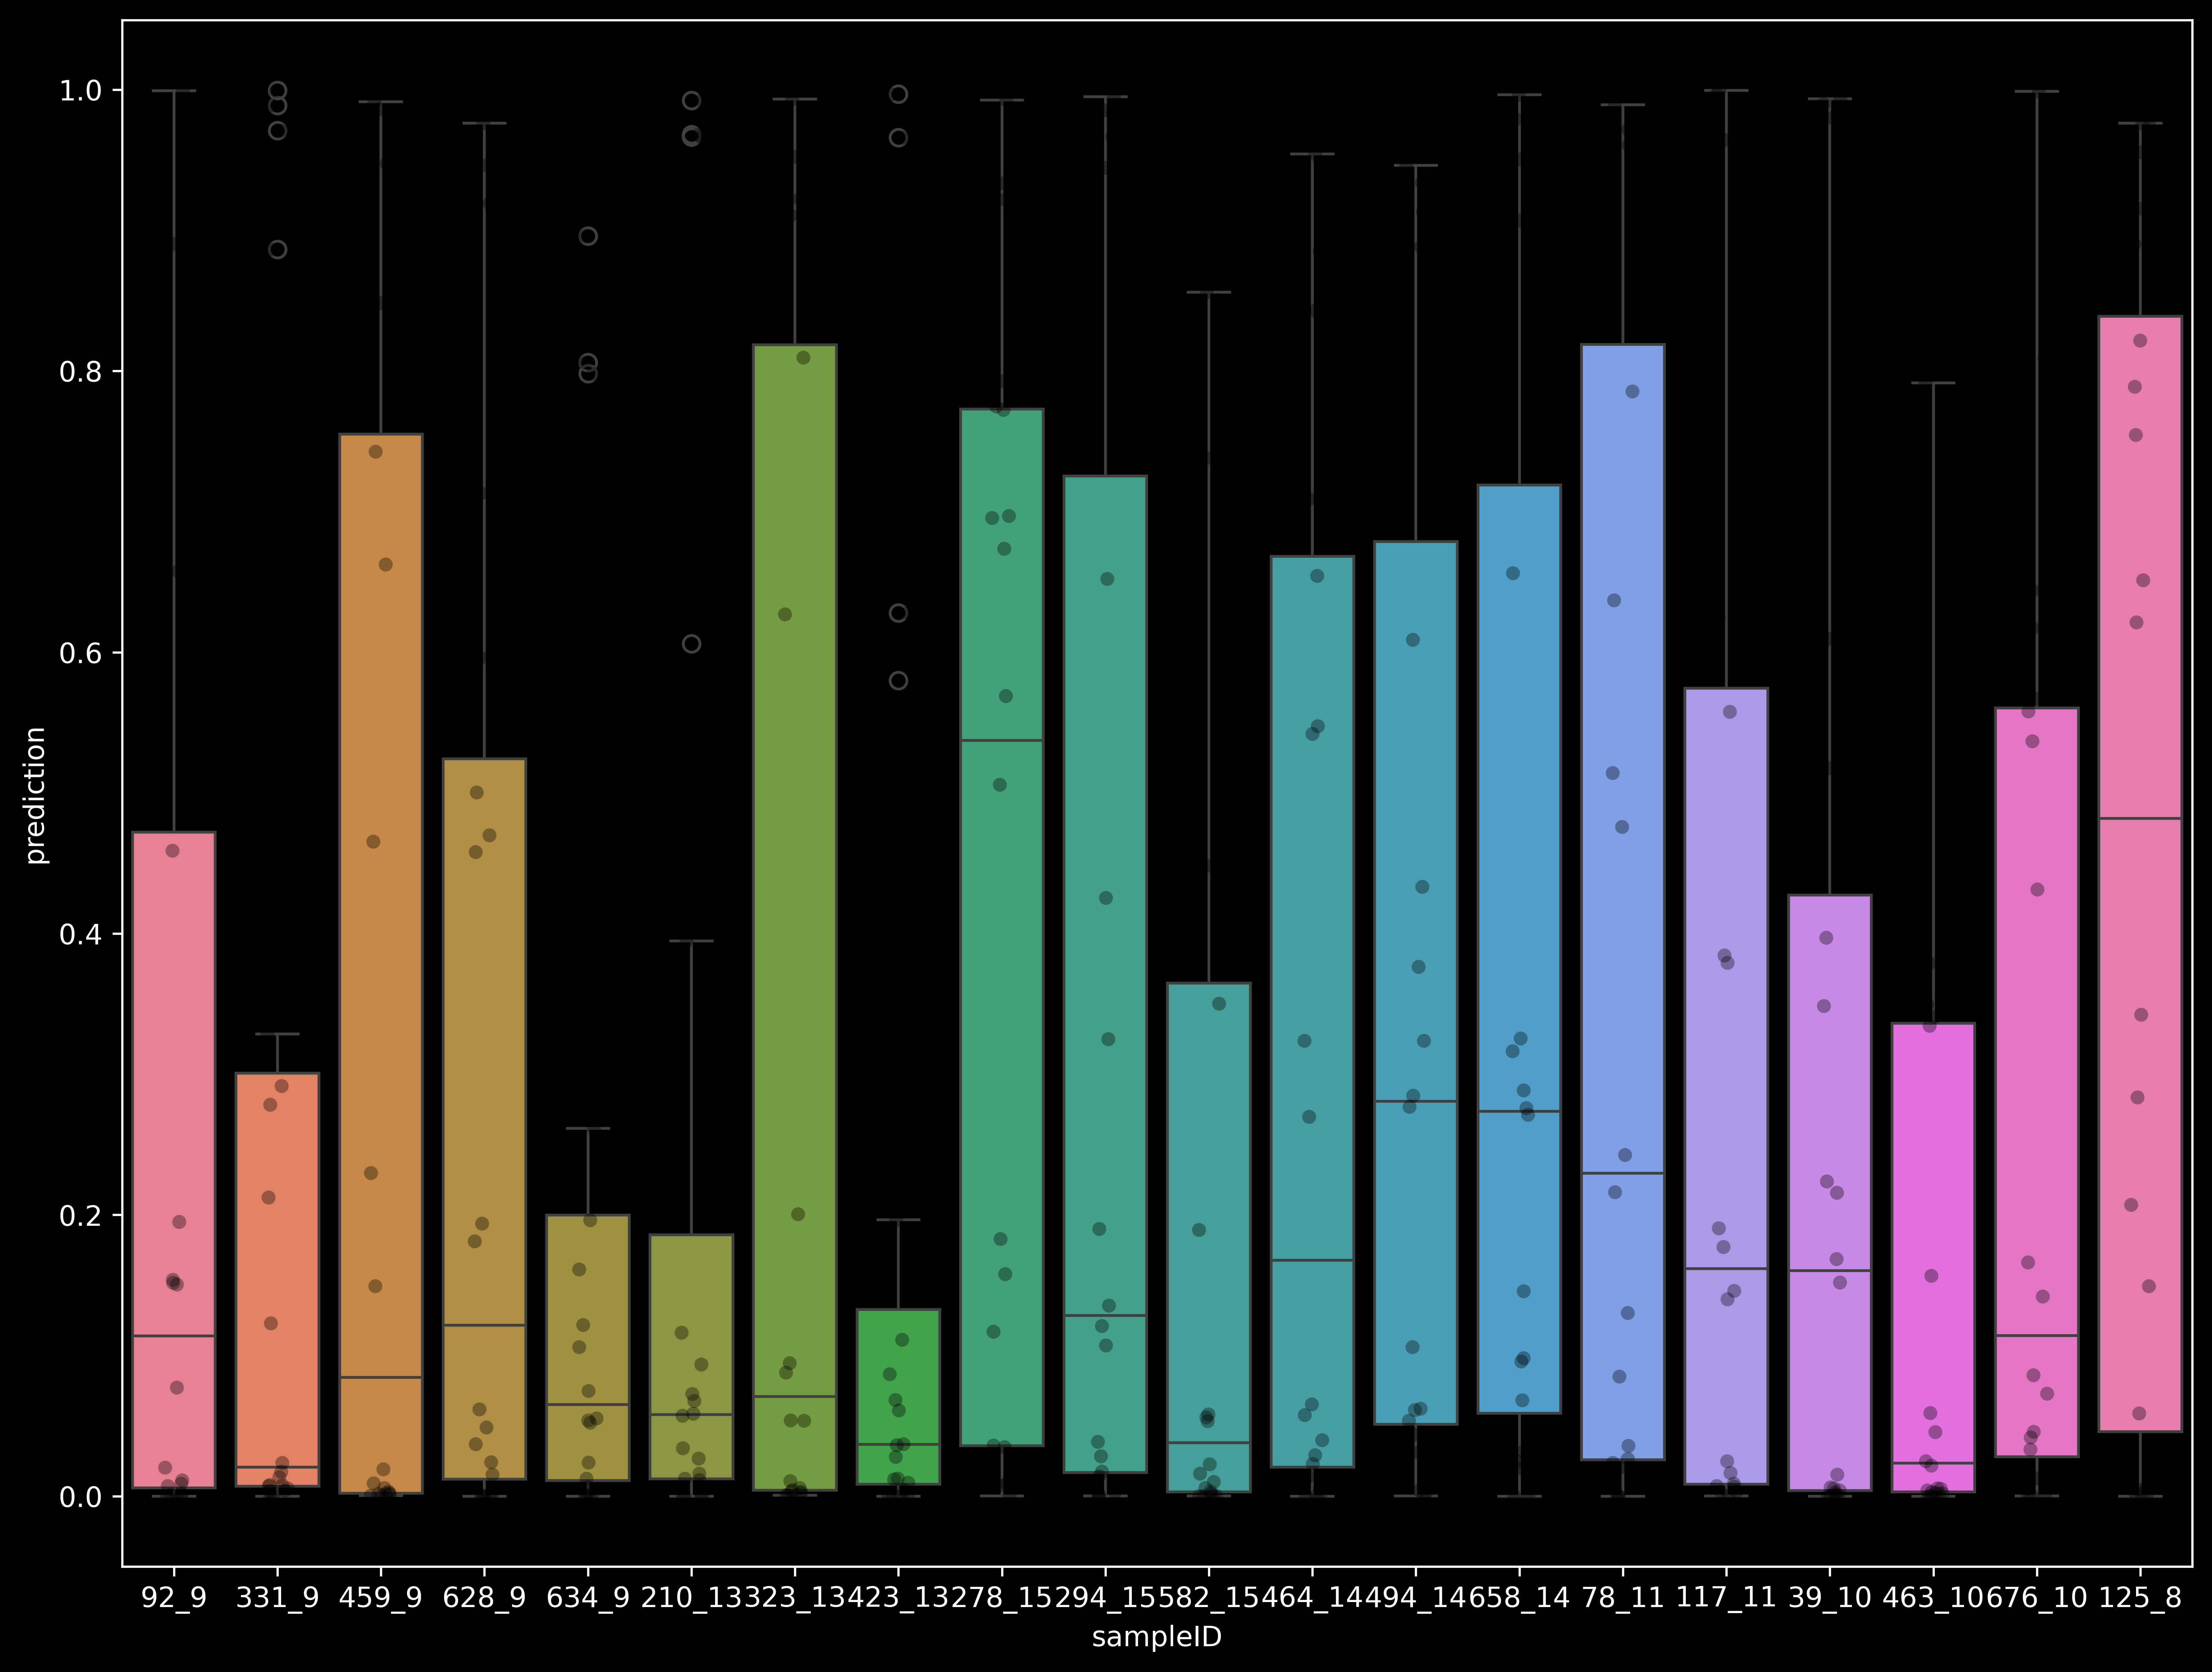

In [45]:
plt.figure(figsize=(13.3, 10), dpi=300)
sns.boxplot(subset, x="sampleID", y="prediction", hue="sampleID")
sns.stripplot(subset, x='sampleID', y='prediction', 
              # color='white', alpha=0.5,
              color='black', alpha=1/3,
              )
plt.show()

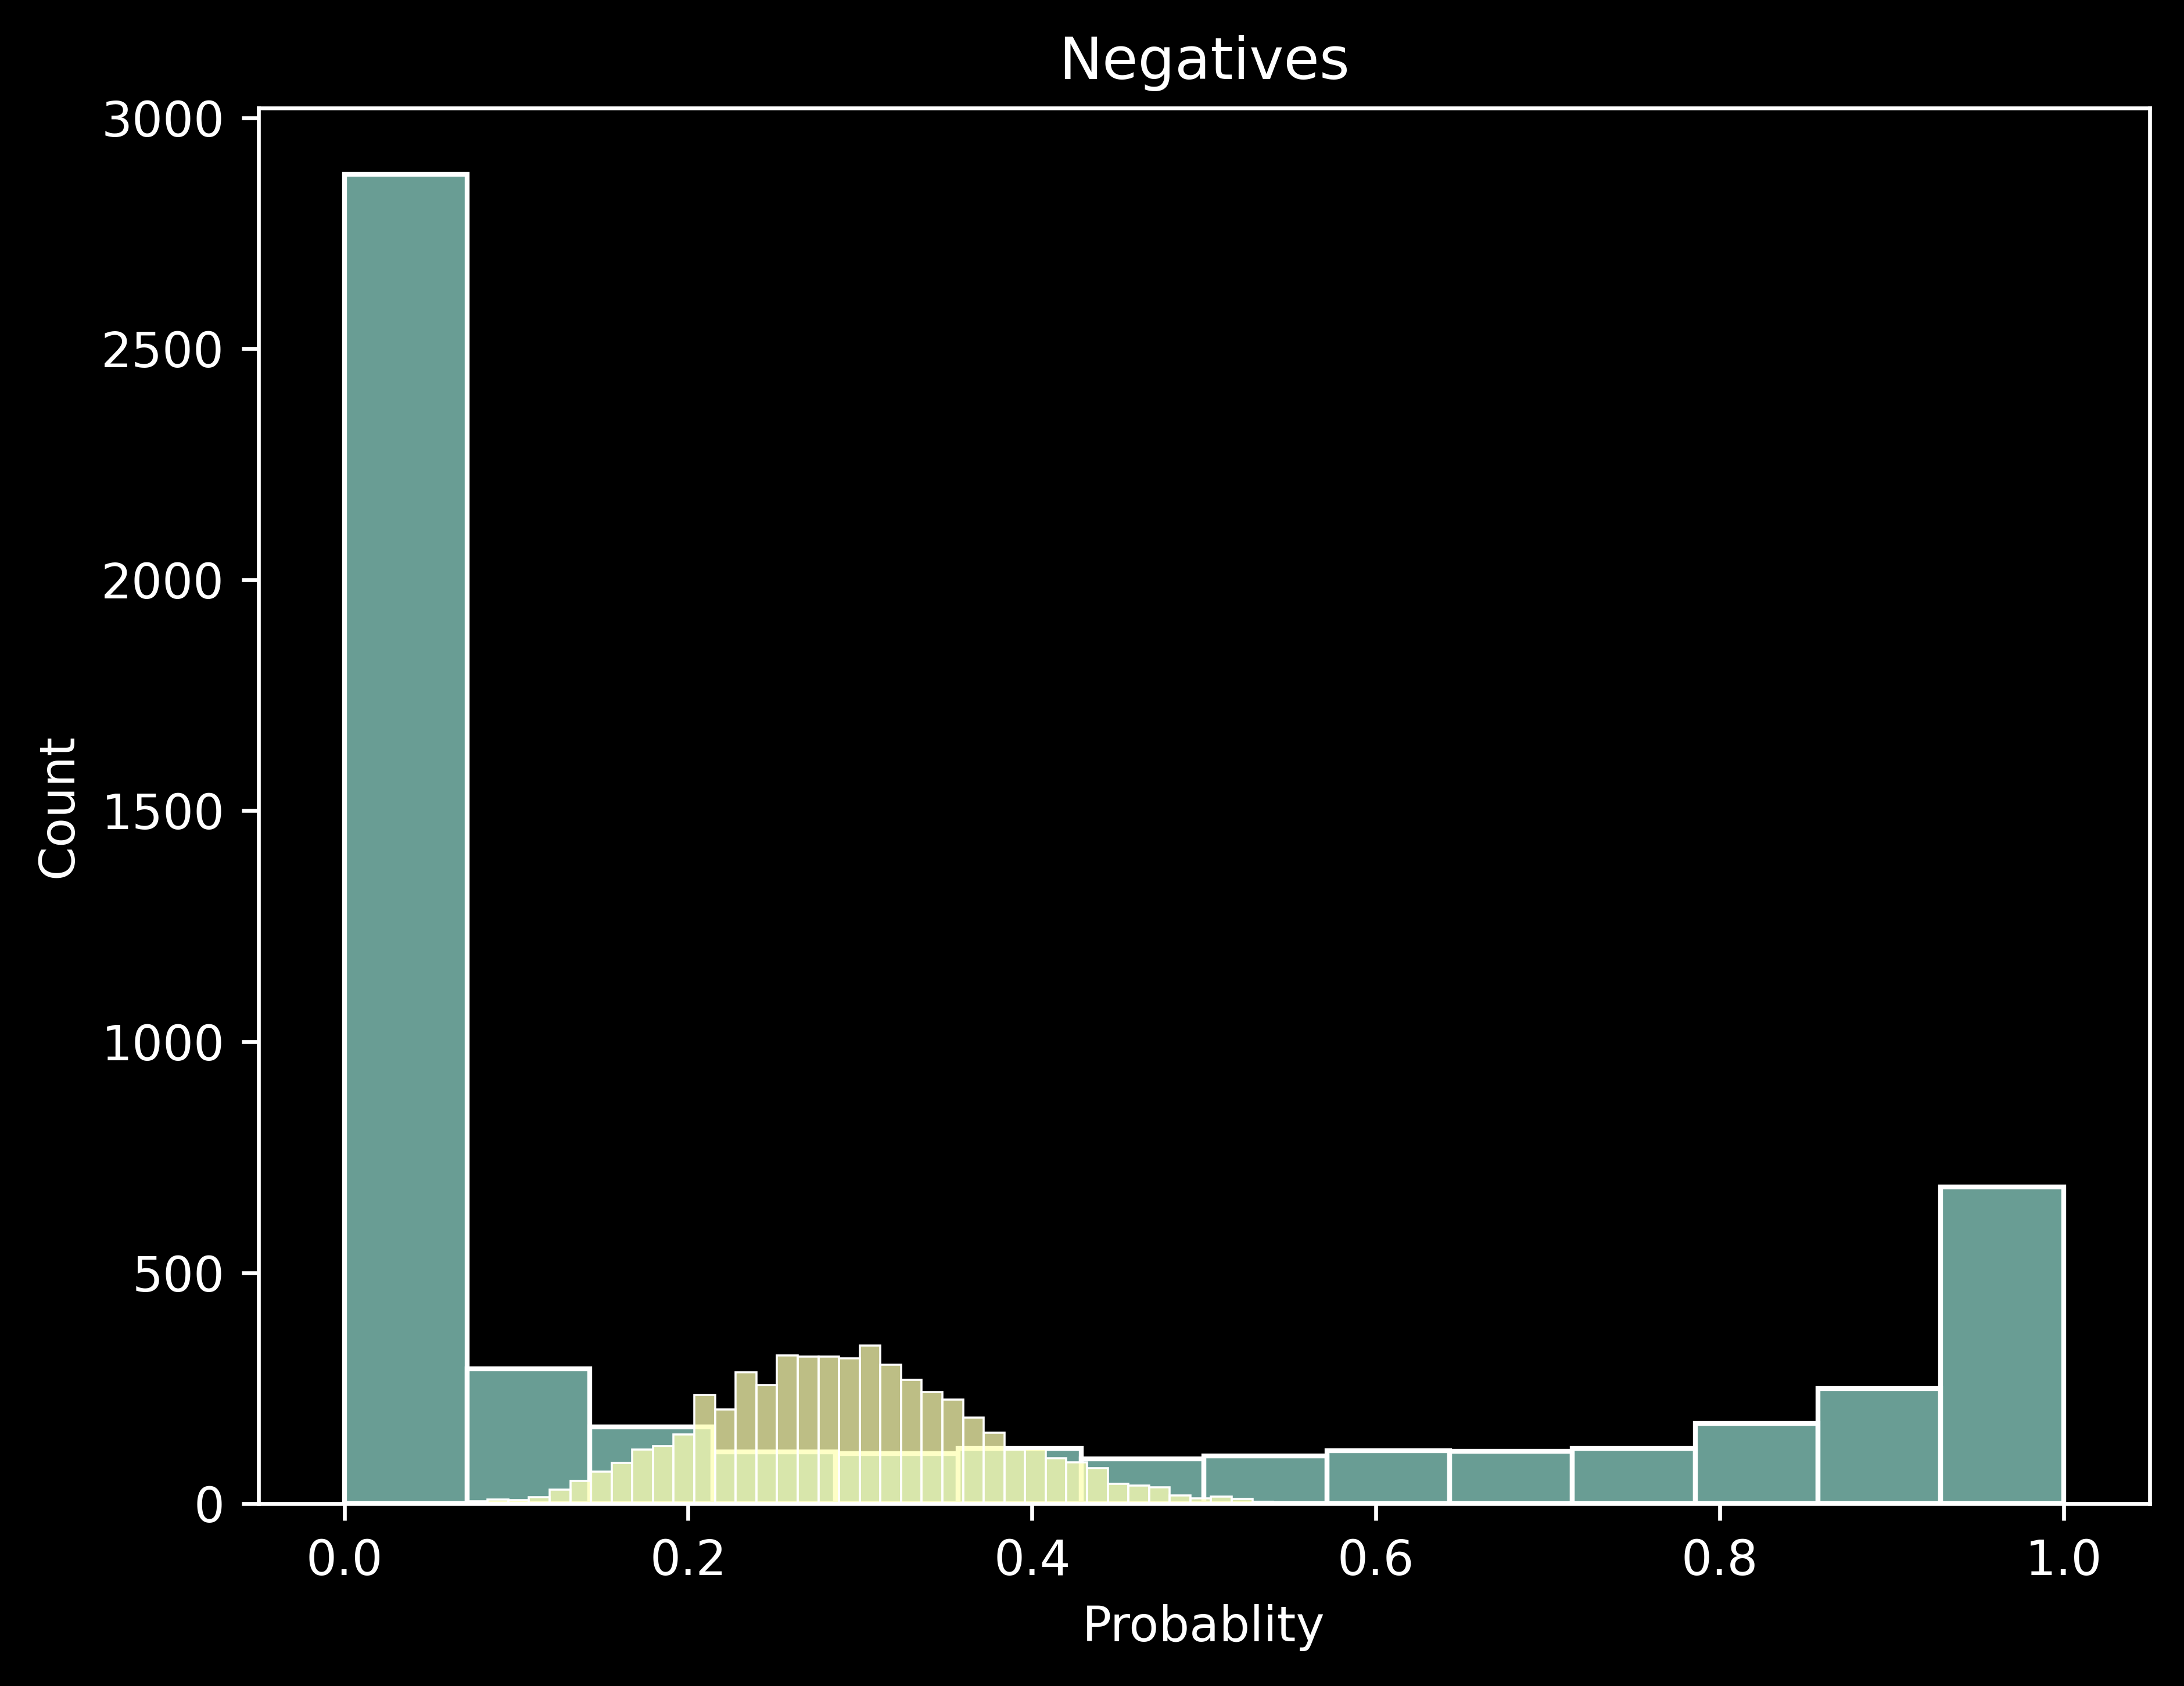

In [46]:
fig = plt.figure(figsize=(7, 5.2), dpi=300)
fig = sns.histplot(data=cdt[cdt.sampleID.isin(negative_indices)], x="wild_type")
fig = sns.histplot(data=cdt[cdt.sampleID.isin(negative_indices)], x="mutant")
fig.set(xlabel="Probablity", title = "Negatives")
plt.show()

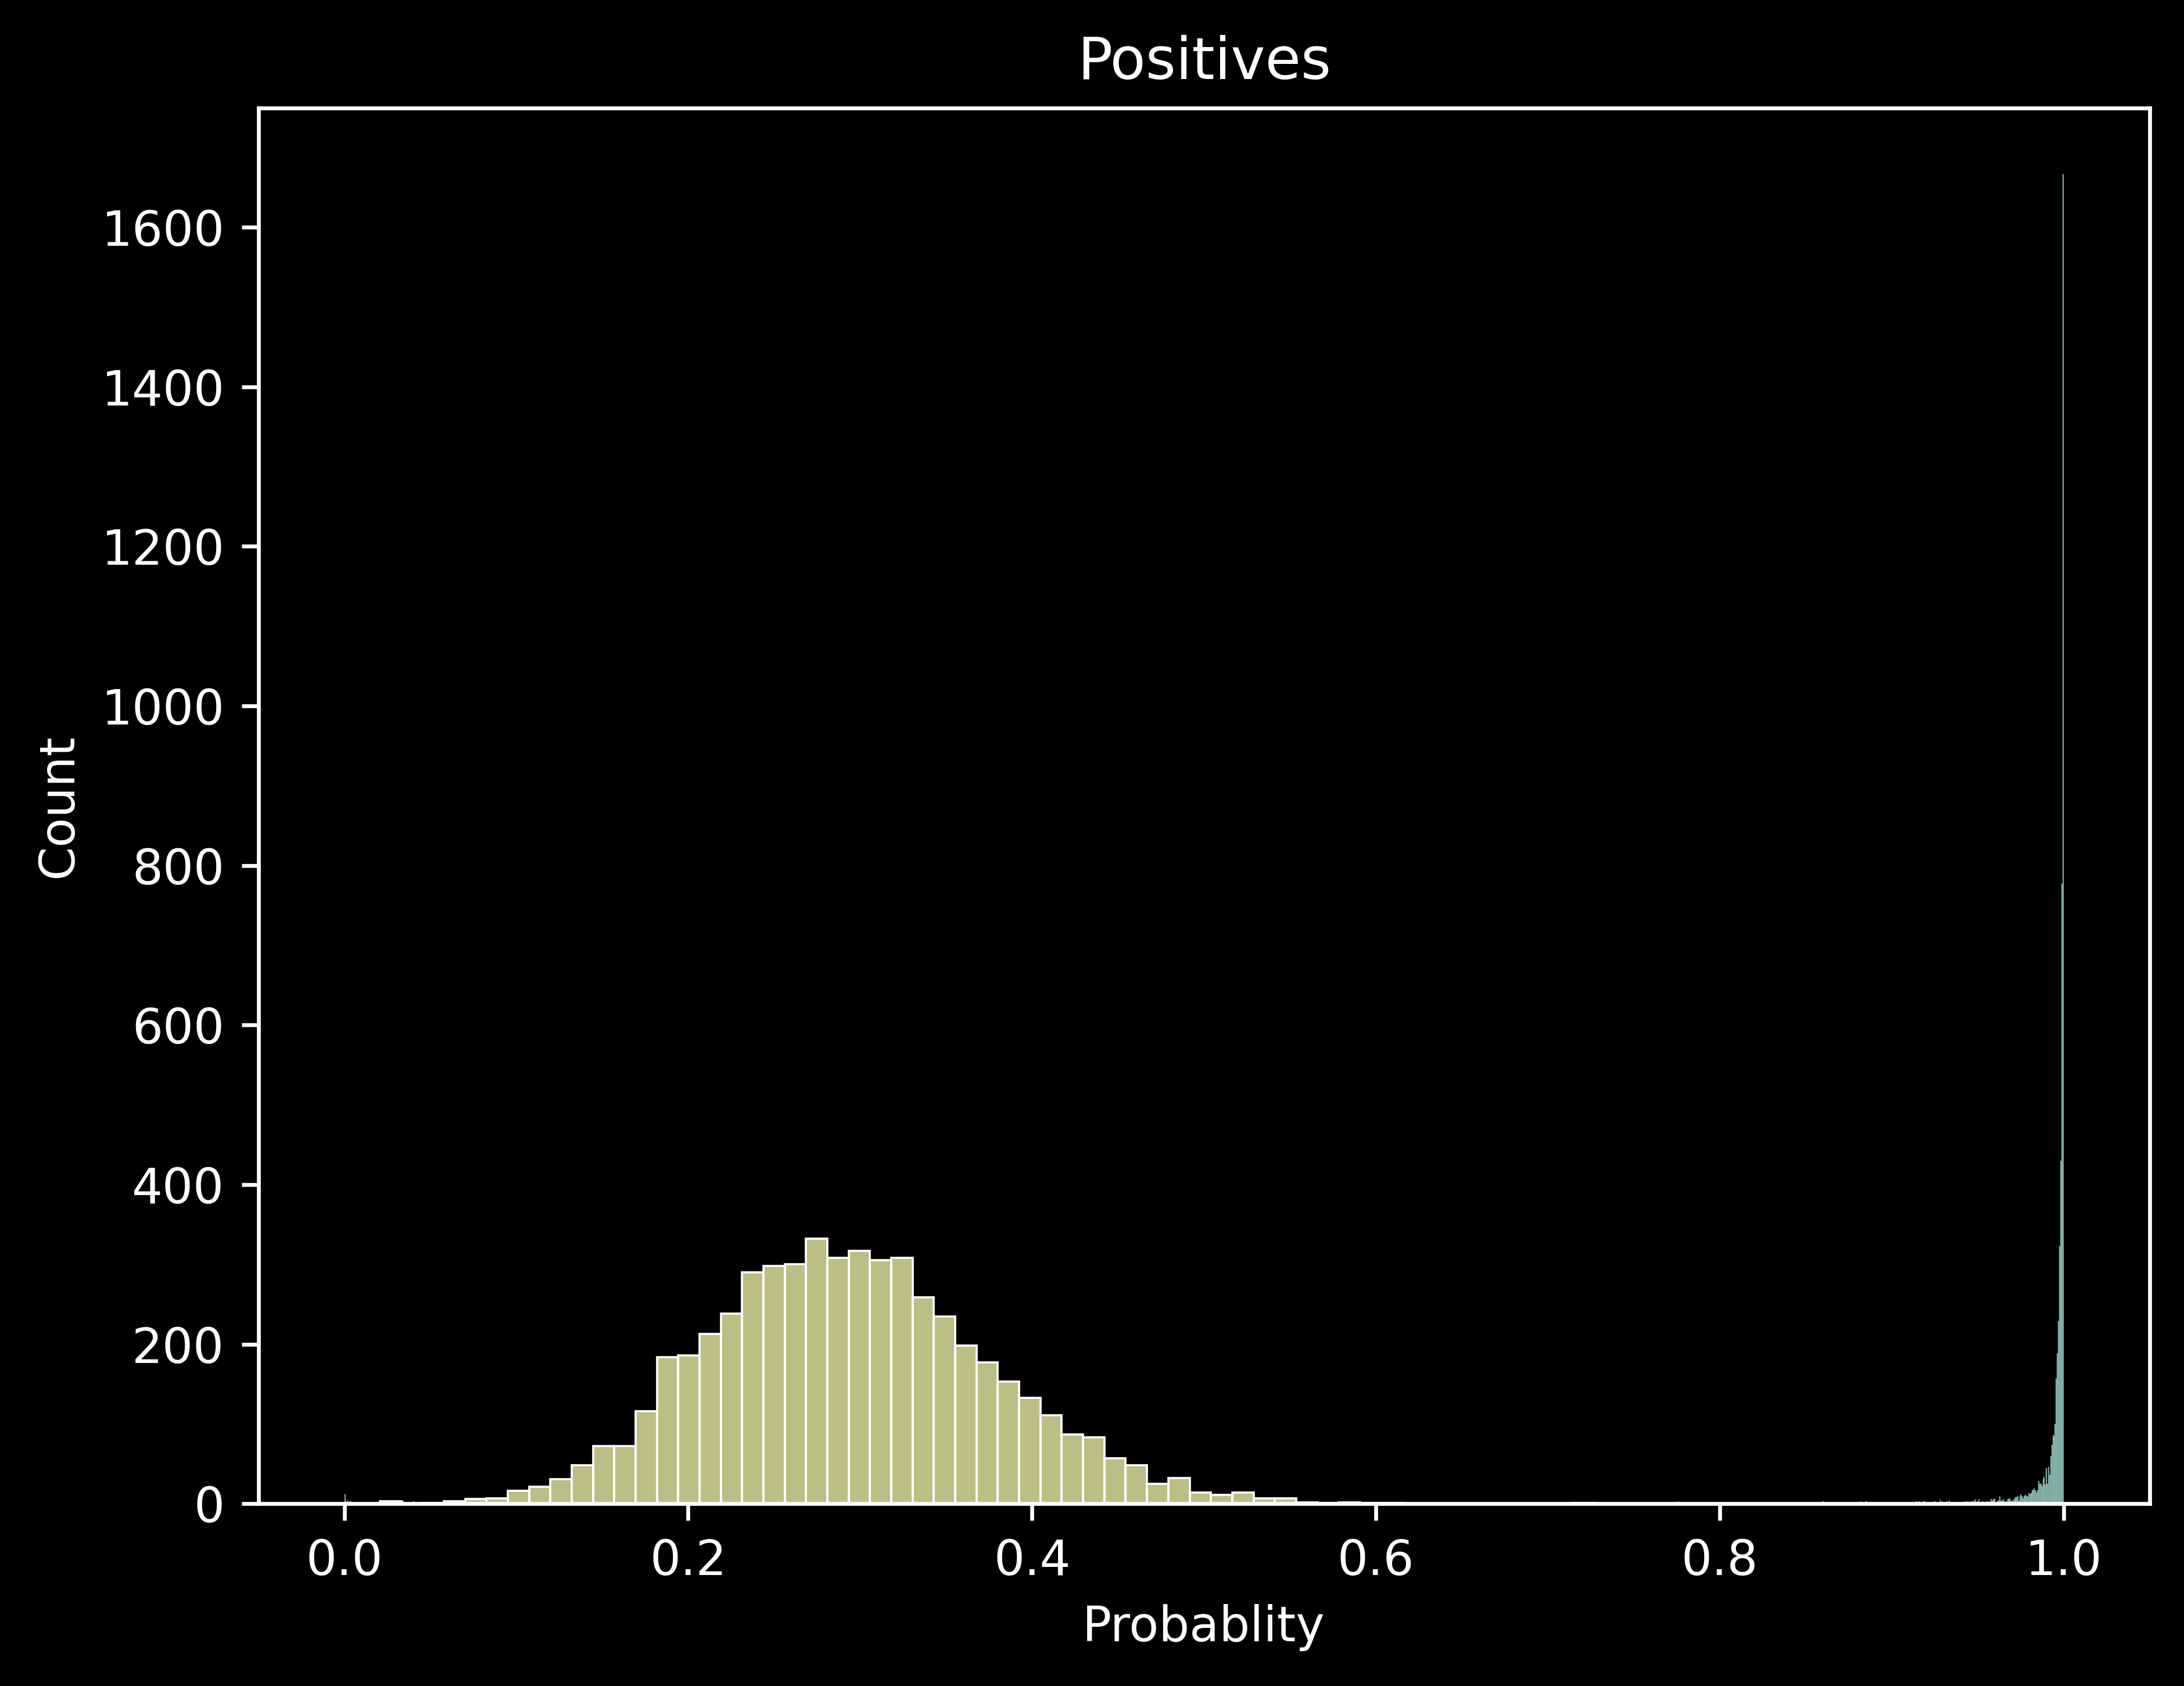

In [47]:
fig = plt.figure(figsize=(7, 5.2), dpi=300)
fig = sns.histplot(data=cdt[cdt.sampleID.isin(positive_indices)], x="wild_type")
fig = sns.histplot(data=cdt[cdt.sampleID.isin(positive_indices)], x="mutant")
fig.set(xlabel="Probablity", title = "Positives")
plt.show()

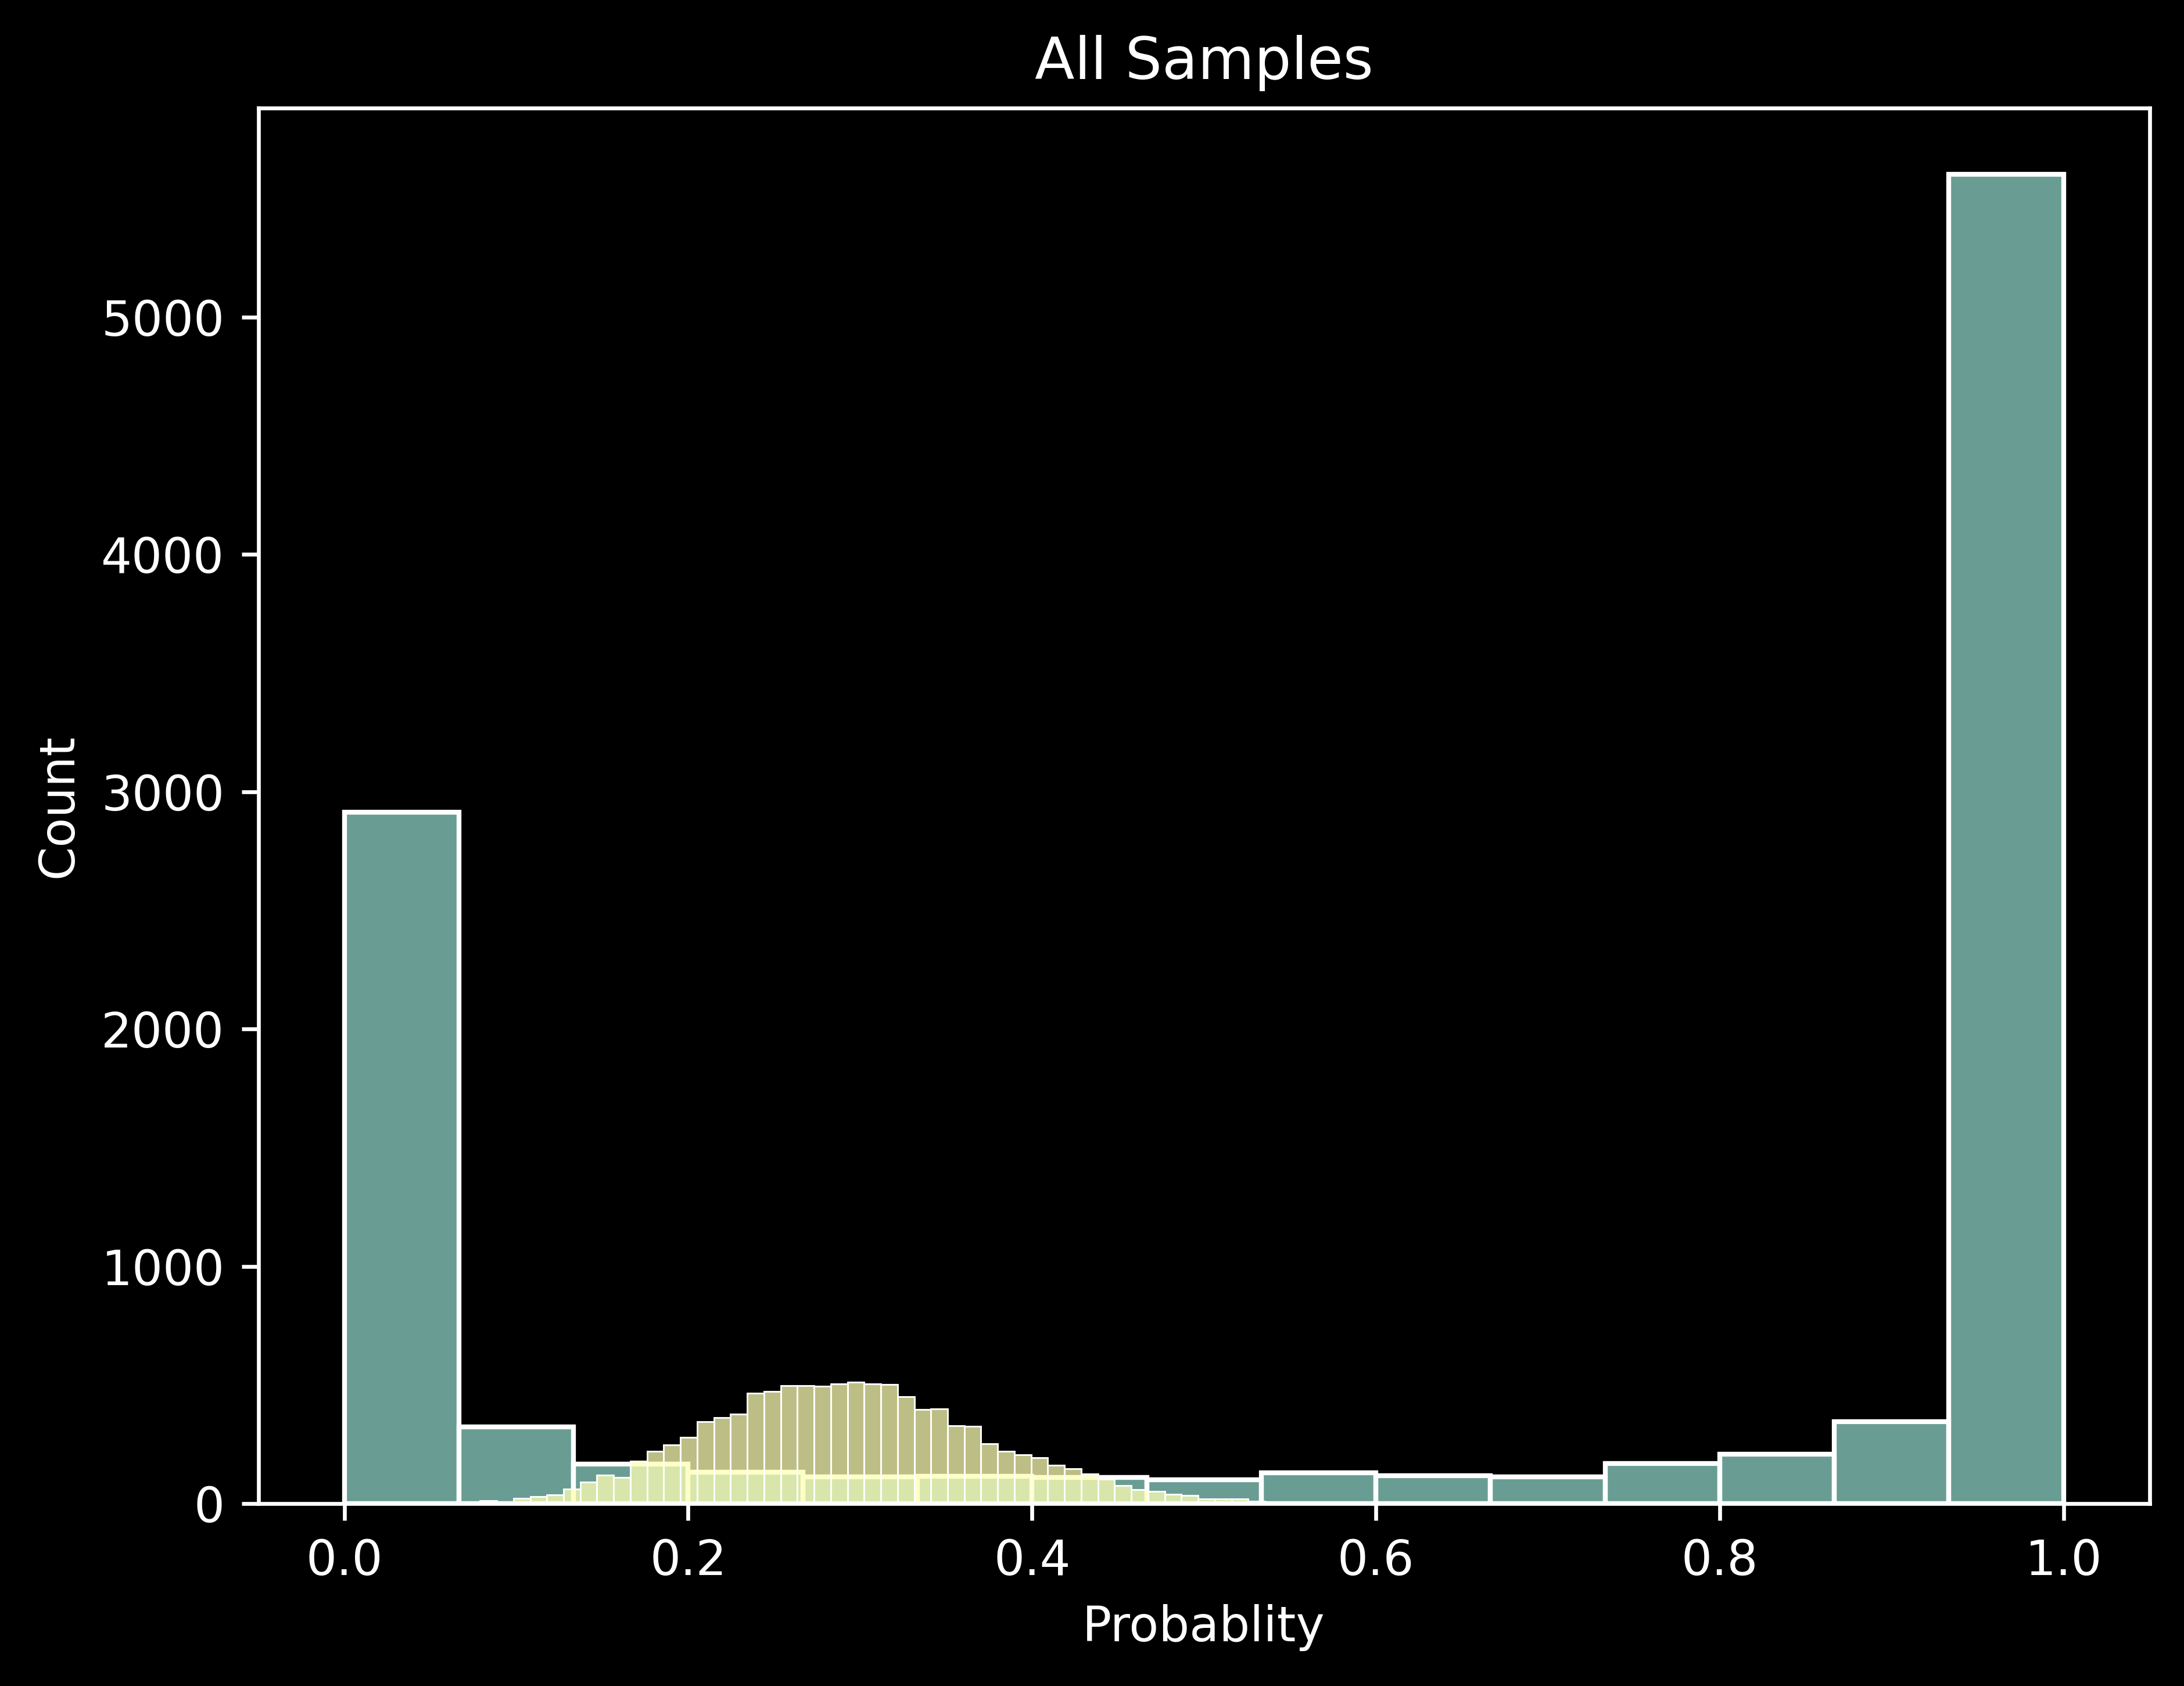

In [ ]:
fig = plt.figure(figsize=(7, 5.2), dpi=300)
fig = sns.histplot(data=cdt, x="wild_type")
fig = sns.histplot(data=cdt, x="mutant")
fig.set(xlabel="Probablity", title = "All Samples")
plt.show()

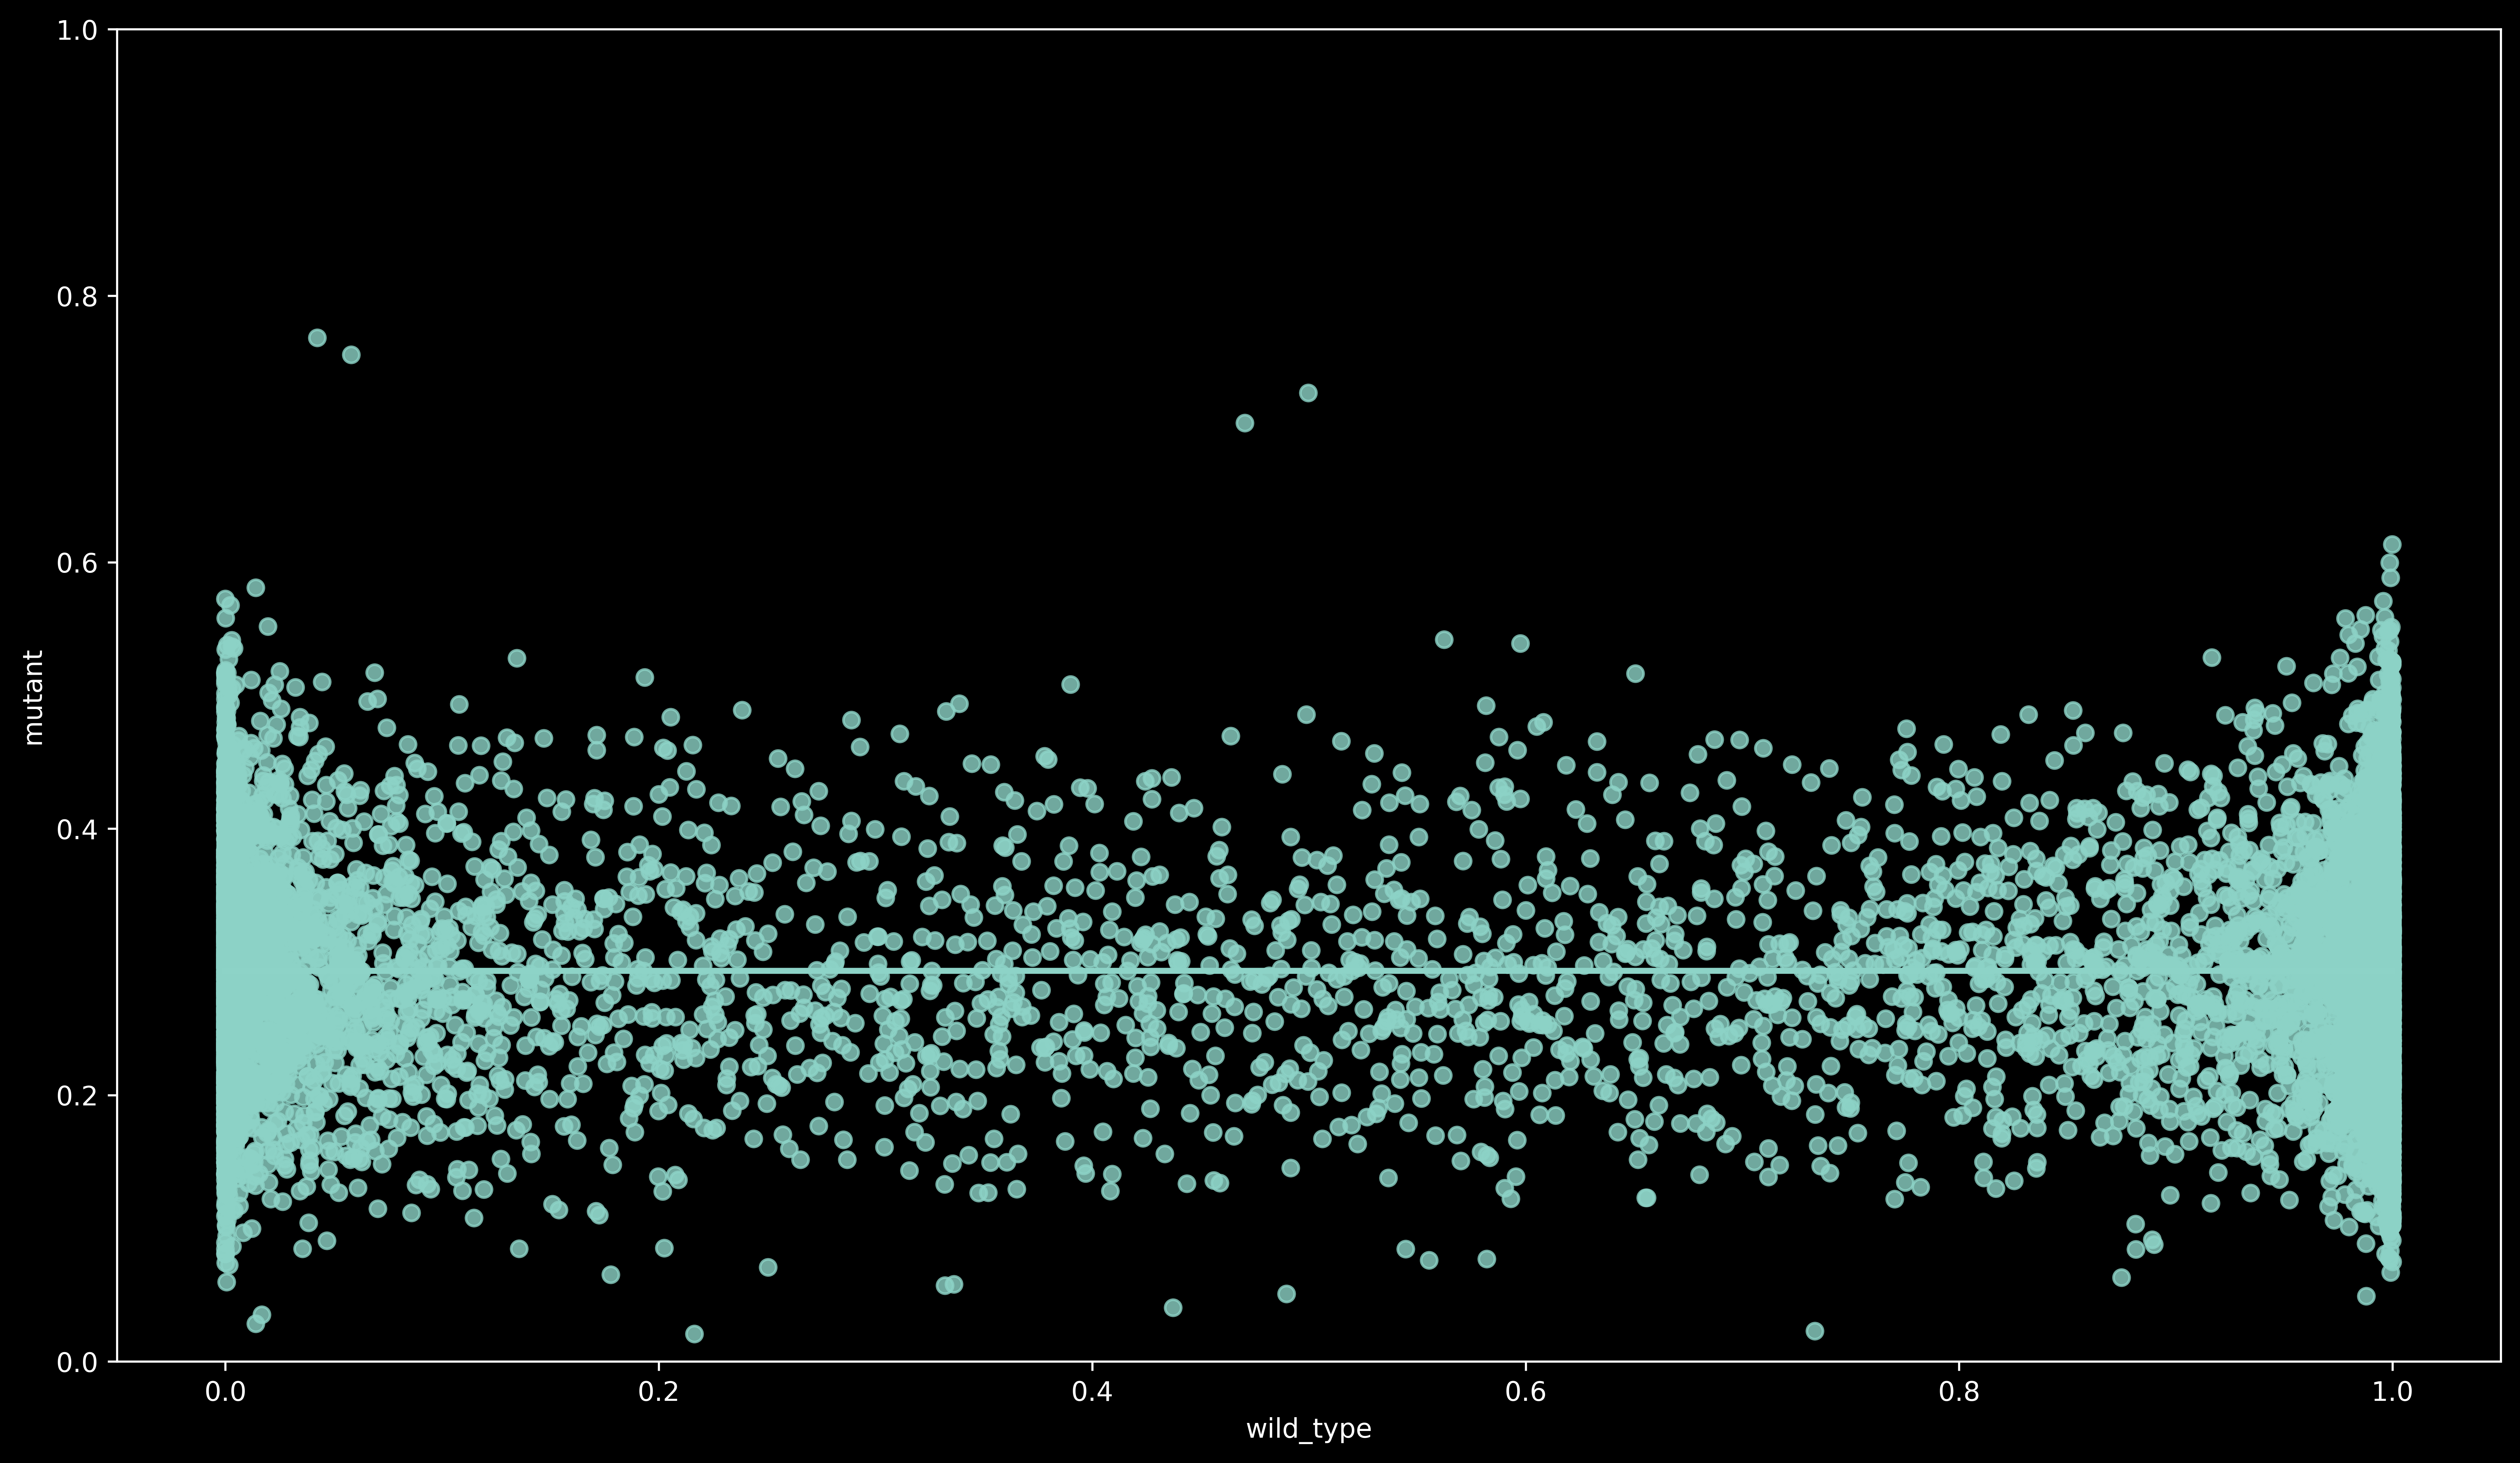

In [ ]:
fig = plt.figure(figsize=(16, 9), dpi=300)
fig = sns.regplot(cdt, x="wild_type", y="mutant")
fig.set(ylim=(0.0, 1.0))
plt.show()

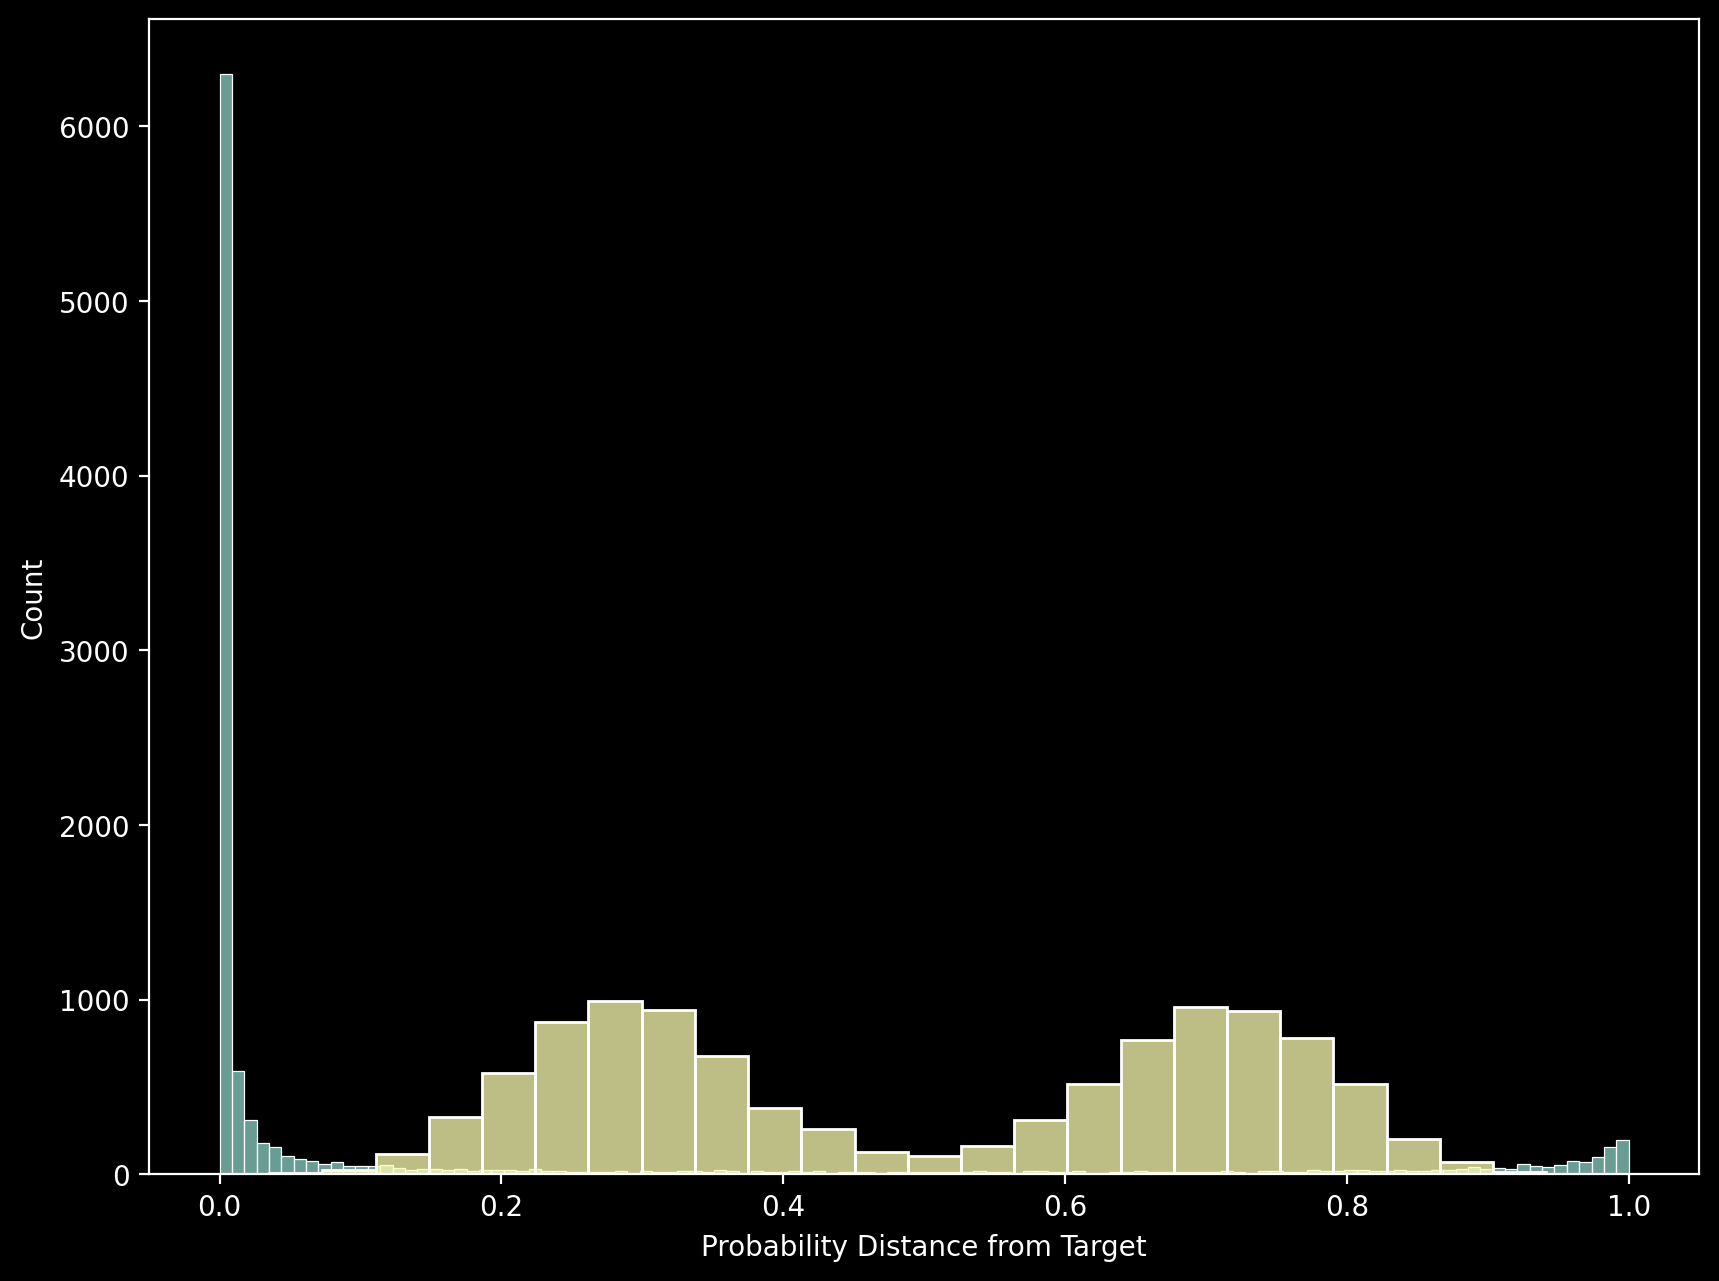

In [ ]:
cdt['wt_distance'] = abs(cdt['target'] - cdt['wild_type'])
cdt['mt_distance'] = abs(cdt['target'] - cdt['mutant'])

# df = cdt[cdt.sampleID.isin(negative_indices)]
df = cdt.copy()
fig = plt.figure(figsize=(10, 7.5))
fig = sns.histplot(df.wt_distance)
fig = sns.histplot(df.mt_distance)
fig.set(xlabel="Probability Distance from Target")
plt.show()

In [ ]:
t_test = stats.ttest_rel(neg_values, pos_values)
print(f"p-value: {t_test.pvalue}")

p-value: 0.6001805849275126
